# Setup notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import STL
from tqdm.notebook import tqdm

sns.set()

import sys

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

In [2]:
wdir = defs.ROOT / "data" / "processed"

Load adjusted tidal data from Sutarkhali

In [48]:
data = pd.read_csv(wdir / "sutarkhali_adjusted.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True)
data.index = pd.DatetimeIndex(data=data.index, freq="infer")

# Tidal model

In [49]:
lat = 22.49984514299519 # Latitude for Sutarkhali Forest Station

# Seasonality and trend removed. Monsoon seasonality is not sinusoidal. Trend will be prescribed seperately.
elev = data.obs.values
time = mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime())

# Solve tidal coefficients
coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=True, nodal=True, constit="auto", verbose=False)

# Add columns for predicted and error
data["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h
data["err"] = data.obs - data.pred

Plot model vs observation

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
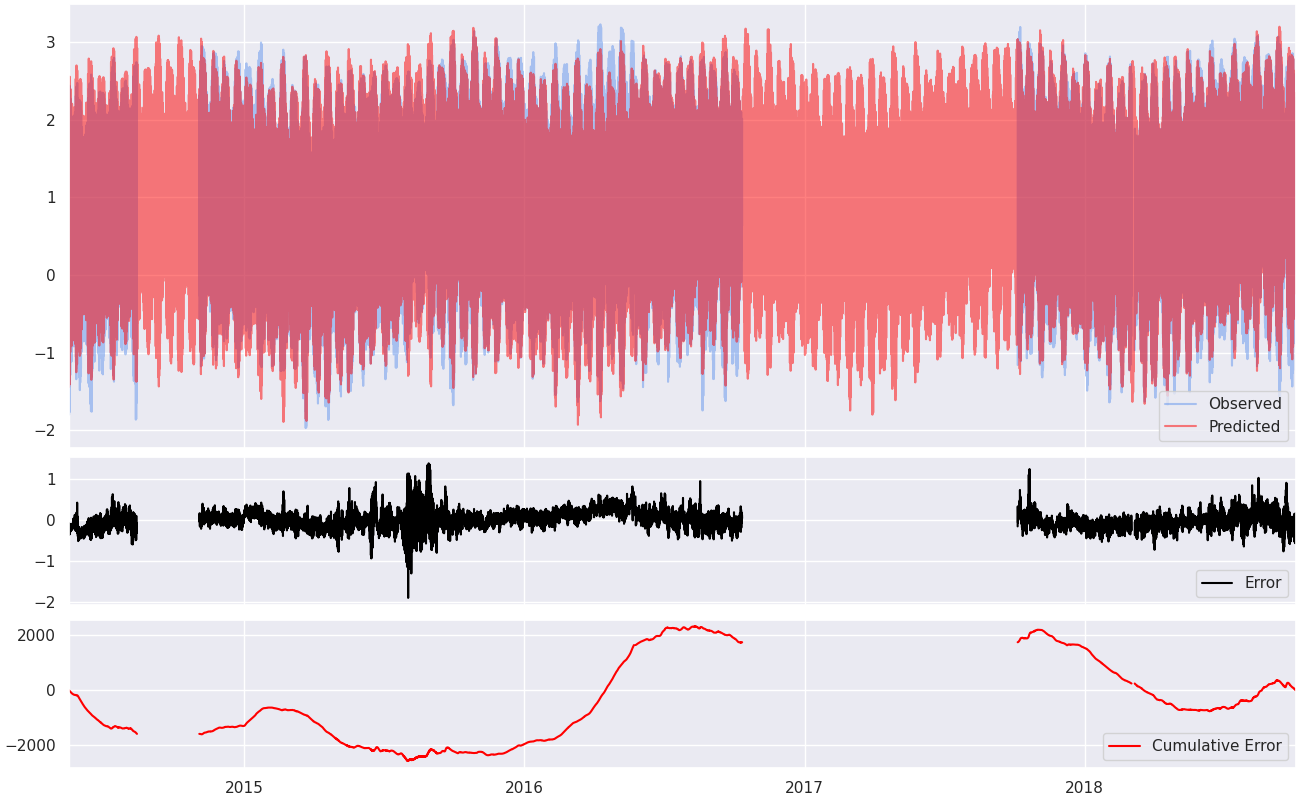

In [50]:
fig, ax = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

freq = "3H"
subset = data.resample(freq).first()
cum_err = data.err.cumsum().resample(freq).first()

subset.obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax[0], label="Observed", legend=True)
subset.pred.plot(kind="line", color="red", alpha=0.5, ax=ax[0], label="Predicted", legend=True)
subset.err.plot(kind="line", ax=ax[1], color="black", label="Error", legend=True)
cum_err.plot(kind="line", ax=ax[2], color="red", label="Cumulative Error", legend=True)

ax[2].set_xlim(data.index[0], data.index[-1]);
ax[2].set_xlabel("");

for a in ax:
    a.legend(loc="lower right")

# Forecast tides

Function to parallelize tidal prediction over multiple years

In [51]:
def make_tides(year, coef, freq, trend=False):
    import copy
    coef = copy.deepcopy(coef)
    coef["aux"]["opt"]["notrend"] = not trend
    
    start = str(year)
    end = str(year+1)
    index = pd.date_range(start=start, end=end, closed="left", freq=freq, name="datetime")
    time = mdates.date2num((index - pd.Timedelta("6 hours")).to_pydatetime())
    elev = utide.reconstruct(t=time, coef=coef, verbose=False).h

    return(pd.Series(data=elev, index=index))

Build multi-year tidal curve

In [52]:
# Parameters for parallel tidal reconstruction
n_jobs = 8
years = np.arange(2010, 2120, 1)
freq = "10S"

# Make tides in parallel and concatenate
tides = Parallel(n_jobs=n_jobs)(delayed(make_tides)(year=year, coef=coef, freq=freq) for year in tqdm(years))
tides = pd.concat(tides)

  0%|          | 0/110 [00:00<?, ?it/s]

Adjust tides so that MHW is 2.55 m (rel. EGM96) during the first year. This is consistent with the approximation from Auerbach et al. (2015).

In [53]:
# Subset first year of tides
subset = tides.loc[str(tides.index[0].year)]

# Terms described by Auerbach et al. (2015). SLR is likely higher but keeping at 3 mm for consistency.
slr = 0.003
mhw = 2.55

# Apply trend
trend = (slr * (subset.index - subset.index[0]) / pd.Timedelta("365.25D")).values
elev = (subset + trend)

# Find high tide
distance = pd.Timedelta("1H") / tides.index.freq * 8
hi = find_peaks(x=elev.values, distance=distance)[0]

# Adjust full tidal data so that MHW during the first year is 2.55 m
adj = mhw - elev.iloc[hi].mean()
tides = tides + adj

Plot the tides to make sure everything looks correct.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
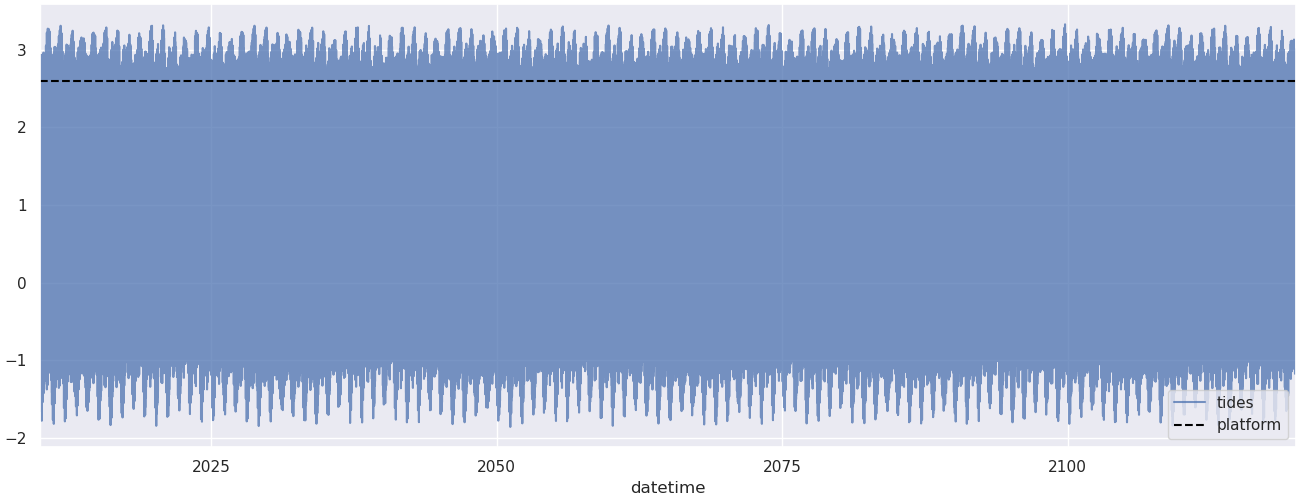

In [56]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

tides.resample("3H").first().plot(ax=ax, alpha=0.75, label="tides", legend=True)
ax.axhline(y=2.6, color="black", ls="--", label="platform")

ax.legend(loc="lower right");

Save tides to feather.

In [67]:
coef["slope"] * 1000

0.08427720664861028

In [62]:
tides.reset_index(name="elevation").to_feather(wdir / "tides.feather")

# Seasonal decomposition

Seasonal decomposition of the monthly medians using STL (loess) regression in R.

In [711]:
%%capture --no-display
%%R -o decomp_r

setwd("~/projects/tidal_flat_0d/data/processed")

library(lubridate)
library(tidyverse)
library(tsibble)
library(imputeTS)
library(forecast)

# Load median adjusted Sutarkhali data
data <- read.csv("sutarkhali_adjusted.csv") |>
  add_row(datetime="2014-05-01 00:00:00", obs=NA) |>
  add_row(datetime="2018-10-31 23:50:00", obs=NA) |>
  mutate(datetime = ymd_hms(datetime)) |>
  as_tsibble(index = datetime) |>
  fill_gaps()

# Get monthly medians for months with >70% data and fill NAs using auto.arima
monthly <- data |>
  index_by(date = ~ yearmonth(.)) |>
  summarize(stat = median(obs, na.rm = TRUE), nulls=mean(is.na(obs))) |>
  fill_gaps()
monthly$stat[monthly$nulls > 0.2] <- NA

# seasonal decomposition
stl <- monthly |>
  select(date, stat) %>%
  {msts(data=.$stat, seasonal.periods = c(12), start=c(year(.$date[1]), month(.$date[1])))} |>
  na_kalman(smooth=TRUE, model="auto.arima") |>
  mstl(robust = FALSE, t.window=6, s.window=12)

# output results as a dataframe
decomp_r <- stl |>
  as_tsibble(pivot_longer=FALSE) |>
  mutate(Date=as.Date(index) + days(14))

Plot STL results

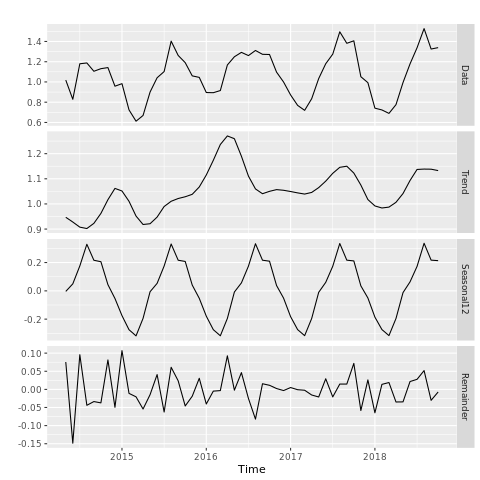

In [712]:
%%R
autoplot(stl)

Convert results to `pd.DataFrame`

In [ ]:
# Format decomp result from R
index = %R as.character(decomp_r$Date)
index = pd.to_datetime(index)
decomp = decomp_r[["Data", "Trend", "Seasonal12", "Remainder"]].set_index(index)
decomp = decomp.rename(columns={"Data": "data", "Trend": "trend", "Seasonal12": "seasonal", "Remainder": "remainder"})

# Calculate mean seasonal to be used for tidal forecasting
mean_seasonal = decomp.seasonal.groupby(decomp.index.month).mean()

index = pd.date_range(
            start=data.index[0]-pd.DateOffset(months=1),
            end=data.index[-1]+pd.DateOffset(months=1),
            freq="MS"
            ) + pd.DateOffset(days=14)
seasonal = mean_seasonal.loc[index.month]
seasonal.index = index

# Add columns for seasonal and trend to the original data
data["seasonal"] = seasonal.asfreq(data.index.freq).interpolate()
data["trend"] = decomp.trend.asfreq(data.index.freq).interpolate()